<a href="https://colab.research.google.com/github/adirsonmfjr/credito-rural/blob/main/Codigo_EstoqCred_GERAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import requests
import pandas as pd
from io import BytesIO

# URL do arquivo no GitHub
url = "https://raw.githubusercontent.com/adirsonmfjr/credito-rural/main/Dados_Estoque_credito_rural_1993-2023.xls"

# Baixar o arquivo
response = requests.get(url)

if response.status_code == 200:
    # Carregar o Excel com ajustes
    df = pd.read_excel(
        BytesIO(response.content),
        sheet_name="Séries",  # Nome da aba no Excel
        engine="xlrd",
        dtype=str  # Lê como string para evitar conversões erradas
    )

    # Converter colunas numéricas para float e substituir NaN por 0
    for col in df.columns[3:]:  # Pular as três primeiras colunas (Sigla, Código, Município)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    print("Arquivo carregado com sucesso!")

else:
    print("Erro ao baixar o arquivo:", response.status_code)

# Configurar pandas para exibir valores sem notação científica
pd.set_option('display.float_format', '{:,.0f}'.format)

# Exibir as primeiras linhas para verificar se faz sentido
df.head()


Arquivo carregado com sucesso!


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,20776771,8562961,11362390,11235470,14613649,15877934,9088736,8996591,6580221,4908745
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,3197656,35660,334018,5179684,1636721,924183,297710,524263,112330,151097
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,8906259,9917391,16527385,13863737,11236307,10363271,7850346,3423072,3098155,3913477
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,16035479,18792652,9158576,10670679,17666324,14845991,6806347,9281610,4009833,3910707
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,4519761,3421325,4075607,3578121,11337150,6119740,3826153,2452279,6232797,3550908


In [50]:
# Identificar as colunas de anos (ignorar as colunas categóricas)
colunas_anos = [col for col in df.columns if col.isdigit()]  # Filtra apenas colunas com nome numérico

# Criar colunas de Data Inicial e Data Final
df["Data_Inicial"] = int(min(colunas_anos))  # Primeiro ano disponível na base
df["Data_Final"] = int(max(colunas_anos))    # Último ano disponível na base

# Criar a coluna de Recência (R)
def calcular_recencia(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com estoque maior que 0

    if anos_validos:
        return df["Data_Final"].iloc[0] - max(anos_validos)  # Último ano de estoque - Data Final
    return df["Data_Final"].iloc[0] - df["Data_Inicial"].iloc[0]  # Caso não tenha estoque, pega o período total

df["Recencia"] = df.apply(calcular_recencia, axis=1)

# Criar a coluna de Frequência (F) - Contagem de anos com estoque positivo
df["Frequencia"] = (df[colunas_anos] > 0).sum(axis=1)

# Criar a coluna Monetário (M) - Soma total dos estoques ao longo do período
df["Monetario"] = df[colunas_anos].sum(axis=1)

# Exibir os dados processados para verificar se está condizente
df.head()


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,2019,2020,2021,2022,2023,Data_Inicial,Data_Final,Recencia,Frequencia,Monetario
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,15877934,9088736,8996591,6580221,4908745,1993,2023,0,29,231741082
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,924183,297710,524263,112330,151097,1993,2023,0,29,41216925
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,10363271,7850346,3423072,3098155,3913477,1993,2023,0,31,177560391
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,14845991,6806347,9281610,4009833,3910707,1993,2023,0,29,257391191
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,6119740,3826153,2452279,6232797,3550908,1993,2023,0,26,98085601


In [54]:
# Criar uma cópia do dataframe para os cálculos LRFM, ampliando para o vínculo/longevidade (L), já que a recência teve variação quase nula
rfm = df.copy()

# Criar a coluna de Longevidade (L) como o intervalo entre o primeiro e o último ano com crédito
def calcular_longevidade(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Anos em que o município pegou crédito

    if anos_validos:
        return max(anos_validos) - min(anos_validos)  # Último ano - Primeiro ano
    return 0  # Caso nunca tenha pego crédito

rfm["Longevidade"] = rfm.apply(calcular_longevidade, axis=1)

# Criar scores LRFM por quintis (de 1 a 5)
rfm["score_L"] = pd.qcut(rfm["Longevidade"], 5, labels=False, duplicates="drop") + 1
rfm["score_R"] = pd.qcut(-rfm["Recencia"], 5, labels=False, duplicates="drop") + 1  # Mantendo score_R original
rfm["score_F"] = pd.qcut(rfm["Frequencia"], 5, labels=False, duplicates="drop") + 1
rfm["score_M"] = pd.qcut(rfm["Monetario"], 5, labels=False, duplicates="drop") + 1

# Criar um score médio entre Frequência e Monetário
rfm["score_FM"] = (rfm["score_F"] + rfm["score_M"]) / 2

# Converter score_FM para inteiro
rfm["score_FM"] = rfm["score_FM"].astype(int)

# Reordenar as colunas conforme a imagem
colunas_anos = [col for col in df.columns if col.isdigit()]  # Pegar colunas numéricas dos anos
colunas_finais = ["Data_Inicial", "Data_Final", "Longevidade","Recencia", "Frequencia", "Monetario", "score_L", "score_R", "score_F", "score_M", "score_FM"]

# Ordenar dataframe conforme desejado
rfm = rfm[colunas_anos + colunas_finais]

# Exportar o arquivo para Excel
rfm.to_excel("/content/segmentacao_RFM_credito_rural.xlsx", index=False, engine="openpyxl")

# Exibir os dados segmentados
rfm.head(30)


,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,Data_Final,Longevidade,Recencia,Frequencia,Monetario,score_L,score_R,score_F,score_M,score_FM
0,0,0,21749,5083039,1180168,3603147,3962375,8959974,3940040,2738098,...,2023,28,0,29,231741082,1,1,2,4,3
1,125701,1764378,294535,0,0,244387,688827,249883,943595,10046,...,2023,30,0,29,41216925,2,1,2,2,2
2,6372470,5486466,3067611,486008,818832,1006212,2966766,2914873,4408776,1965025,...,2023,30,0,31,177560391,2,1,2,4,3
3,0,0,569863,13844,108046,293693,635708,4778237,9029253,8316244,...,2023,28,0,29,257391191,1,1,2,4,3
4,0,0,0,0,104771,560449,0,466463,2098383,2065990,...,2023,26,0,26,98085601,1,1,1,3,2
5,4174121,9793970,2930975,740449,45919,25763,4497267,6595863,756518,1941597,...,2023,30,0,31,73294608,2,1,2,3,2
6,0,0,0,0,17272,0,691557,1276425,1006598,146678,...,2023,26,0,26,62018956,1,1,1,3,2
7,157460,736830,0,1741801,606447,152267,1598423,986712,1981464,1051664,...,2023,30,0,30,64958872,2,1,2,3,2
8,0,0,0,0,0,0,0,114865,0,0,...,2023,23,0,14,1310817,1,1,1,1,1
9,0,0,0,0,0,0,45506,1128672,544694,1925014,...,2023,24,0,25,17574727,1,1,1,1,1


In [63]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalizar os dados antes do PCA
scaler = StandardScaler()
df_scaled_pca = scaler.fit_transform(rfm[["Frequencia", "Monetario", "Longevidade"]])

# Aplicar PCA para redução de dimensionalidade
pca = PCA()
pca_result = pca.fit_transform(df_scaled_pca)

# Criar a coluna de ranking LRFM com base no primeiro componente principal (PCA)
rfm["ranking_LRFM"] = np.argsort(-pca_result[:, 0])  # Ordenação decrescente

# Aplicar K-Means com mais clusters para refinar a segmentação
kmeans = KMeans(n_clusters=7, n_init=25, random_state=123)  # Aumentei os clusters de 5 para 7
rfm["cluster"] = kmeans.fit_predict(df_scaled_pca)

# Criar um escore composto para segmentação ficar mais evidente
rfm["score_composto"] = (rfm["score_L"] * 1.5) + (rfm["score_F"] * 1.2) + (rfm["score_M"] * 1.0)

# Definir faixas dinâmicas com base na distribuição real dos dados
p_composto = np.percentile(rfm["score_composto"], [20, 40, 60, 80])

# Criar novas condições, agora incluindo o escore composto
condicoes = [
    (rfm["score_composto"] > p_composto[3]),
    (rfm["score_composto"] > p_composto[2]),
    (rfm["score_composto"] > p_composto[1]),
    (rfm["score_composto"] > p_composto[0]),
    (rfm["cluster"] == 3) | (rfm["cluster"] == 4),
    (rfm["cluster"] == 5) | (rfm["cluster"] == 6),
]

# Criar novas categorias
categorias = [
    "Alta Demanda Regular",  # Municípios que usam crédito com alta frequência e em grandes volumes.
    "Demanda Consistente",   # Municípios que acessam crédito regularmente, mas com volumes moderados.
    "Uso Contínuo",          # Municípios que mantêm um padrão de uso constante.
    "Potencial de Crescimento",  # Municípios que estão aumentando a utilização de crédito.
    "Baixa Demanda",         # Municípios que acessam crédito de forma intermitente.
    "Declínio de Crédito",   # Municípios que reduziram o uso de crédito, mas ainda acessam.
]

# Aplicando a classificação ao dataframe
rfm["classificacao_LRFM"] = np.select(condicoes, categorias, default="Inativo")

# Criar fallback para municípios classificados como "Outros Municípios"
rfm.loc[rfm["classificacao_LRFM"] == "Outros Municípios", "classificacao_LRFM"] = "Baixa Demanda"

# Reordenar as colunas
colunas_anos = [col for col in df.columns if col.isdigit()]  # Pegar colunas numéricas dos anos
colunas_finais = [
    "Data_Inicial", "Data_Final", "Recencia", "Longevidade", "Frequencia", "Monetario",
    "score_R", "score_L", "score_F", "score_M", "score_FM",
    "ranking_LRFM", "cluster", "score_composto", "classificacao_LRFM"
]

# Ordenar dataframe conforme desejado
rfm = rfm[colunas_anos + colunas_finais]

# Exibir os dados segmentados
rfm.head(30)

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,Monetario,score_R,score_L,score_F,score_M,score_FM,ranking_LRFM,cluster,score_composto,classificacao_LRFM
0,0,0,21749,5083039,1180168,3603147,3962375,8959974,3940040,2738098,...,231741082,1,1,2,4,3,5373,0,8,Uso Contínuo
1,125701,1764378,294535,0,0,244387,688827,249883,943595,10046,...,41216925,1,2,2,2,2,1089,0,7,Potencial de Crescimento
2,6372470,5486466,3067611,486008,818832,1006212,2966766,2914873,4408776,1965025,...,177560391,1,2,2,4,3,3270,0,9,Demanda Consistente
3,0,0,569863,13844,108046,293693,635708,4778237,9029253,8316244,...,257391191,1,1,2,4,3,4879,0,8,Uso Contínuo
4,0,0,0,0,104771,560449,0,466463,2098383,2065990,...,98085601,1,1,1,3,2,1680,3,6,Baixa Demanda
5,4174121,9793970,2930975,740449,45919,25763,4497267,6595863,756518,1941597,...,73294608,1,2,2,3,2,553,0,8,Uso Contínuo
6,0,0,0,0,17272,0,691557,1276425,1006598,146678,...,62018956,1,1,1,3,2,4506,3,6,Baixa Demanda
7,157460,736830,0,1741801,606447,152267,1598423,986712,1981464,1051664,...,64958872,1,2,2,3,2,3400,0,8,Uso Contínuo
8,0,0,0,0,0,0,0,114865,0,0,...,1310817,1,1,1,1,1,2412,1,4,Inativo
9,0,0,0,0,0,0,45506,1128672,544694,1925014,...,17574727,1,1,1,1,1,3459,3,4,Baixa Demanda


<ipython-input-73-08e9ad9d7499>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


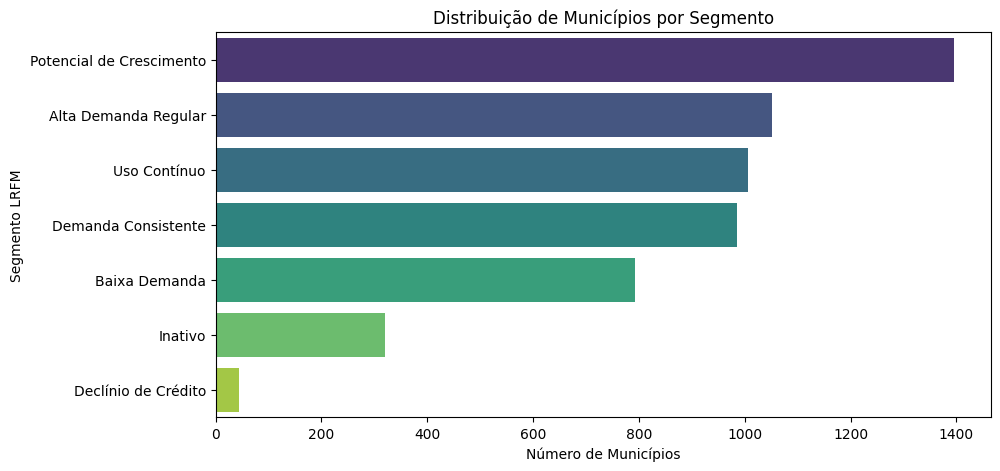

<ipython-input-73-08e9ad9d7499>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_filtrado, x="classificacao_LRFM", y="Recencia", palette="viridis", ax=axes[0])
<ipython-input-73-08e9ad9d7499>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-73-08e9ad9d7499>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_filtrado, x="classificacao_LRFM", y="Longevidade", palette="viridis", ax=axes[1])
<ipython-input-73-08e9ad9d7499>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. afte

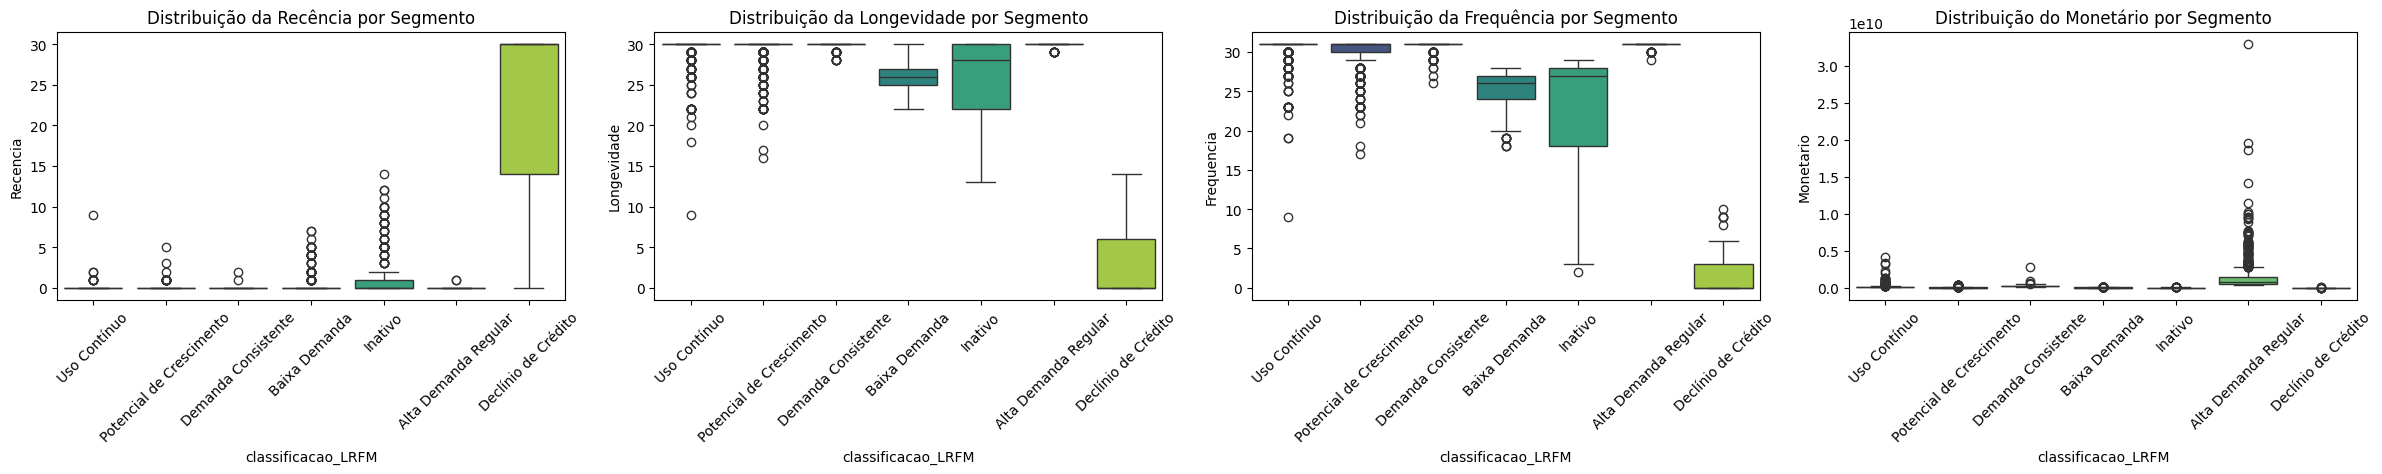

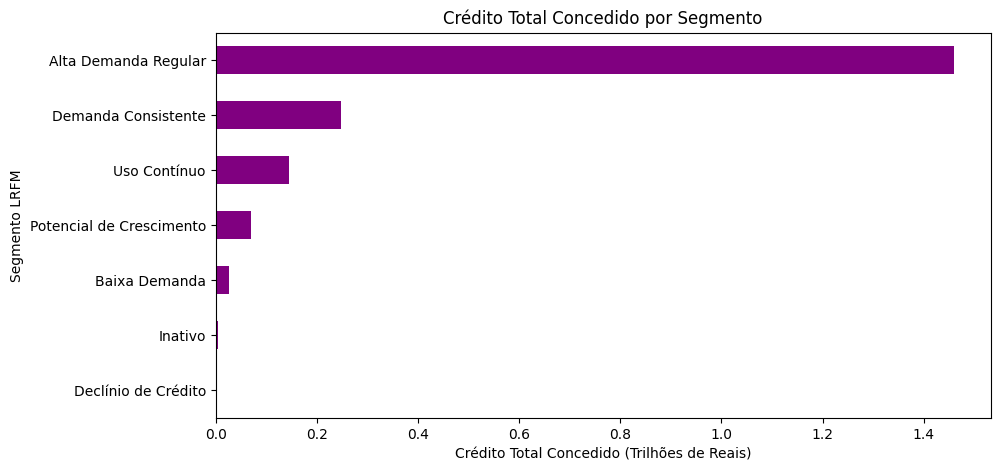

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar dados removendo "Outros Municípios" para uma análise mais relevante
rfm_filtrado = rfm[rfm["classificacao_LRFM"] != "Outros Municípios"]

# 1️⃣ Gráfico de Barras - Quantidade de Municípios por Segmento
plt.figure(figsize=(10, 5))
sns.countplot(
    y=rfm_filtrado["classificacao_LRFM"],
    order=rfm_filtrado["classificacao_LRFM"].value_counts().index,
    palette="viridis"
)
plt.xlabel("Número de Municípios")
plt.ylabel("Segmento LRFM")
plt.title("Distribuição de Municípios por Segmento")
plt.show()

# 2️⃣ Boxplot - Comparação de Recência, Longevidade, Frequência e Monetário por Segmento
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

sns.boxplot(data=rfm_filtrado, x="classificacao_LRFM", y="Recencia", palette="viridis", ax=axes[0])
axes[0].set_title("Distribuição da Recência por Segmento")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm_filtrado, x="classificacao_LRFM", y="Longevidade", palette="viridis", ax=axes[1])
axes[1].set_title("Distribuição da Longevidade por Segmento")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm_filtrado, x="classificacao_LRFM", y="Frequencia", palette="viridis", ax=axes[2])
axes[2].set_title("Distribuição da Frequência por Segmento")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm_filtrado, x="classificacao_LRFM", y="Monetario", palette="viridis", ax=axes[3])
axes[3].set_title("Distribuição do Monetário por Segmento")
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 3️⃣ Crédito Total Concedido por Segmento (Monetário Total)
plt.figure(figsize=(10, 5))
(rfm_filtrado.groupby("classificacao_LRFM")["Monetario"].sum() / 1e12).sort_values().plot(kind="barh", color="purple")
plt.xlabel("Crédito Total Concedido (Trilhões de Reais)")
plt.ylabel("Segmento LRFM")
plt.title("Crédito Total Concedido por Segmento")
plt.show()


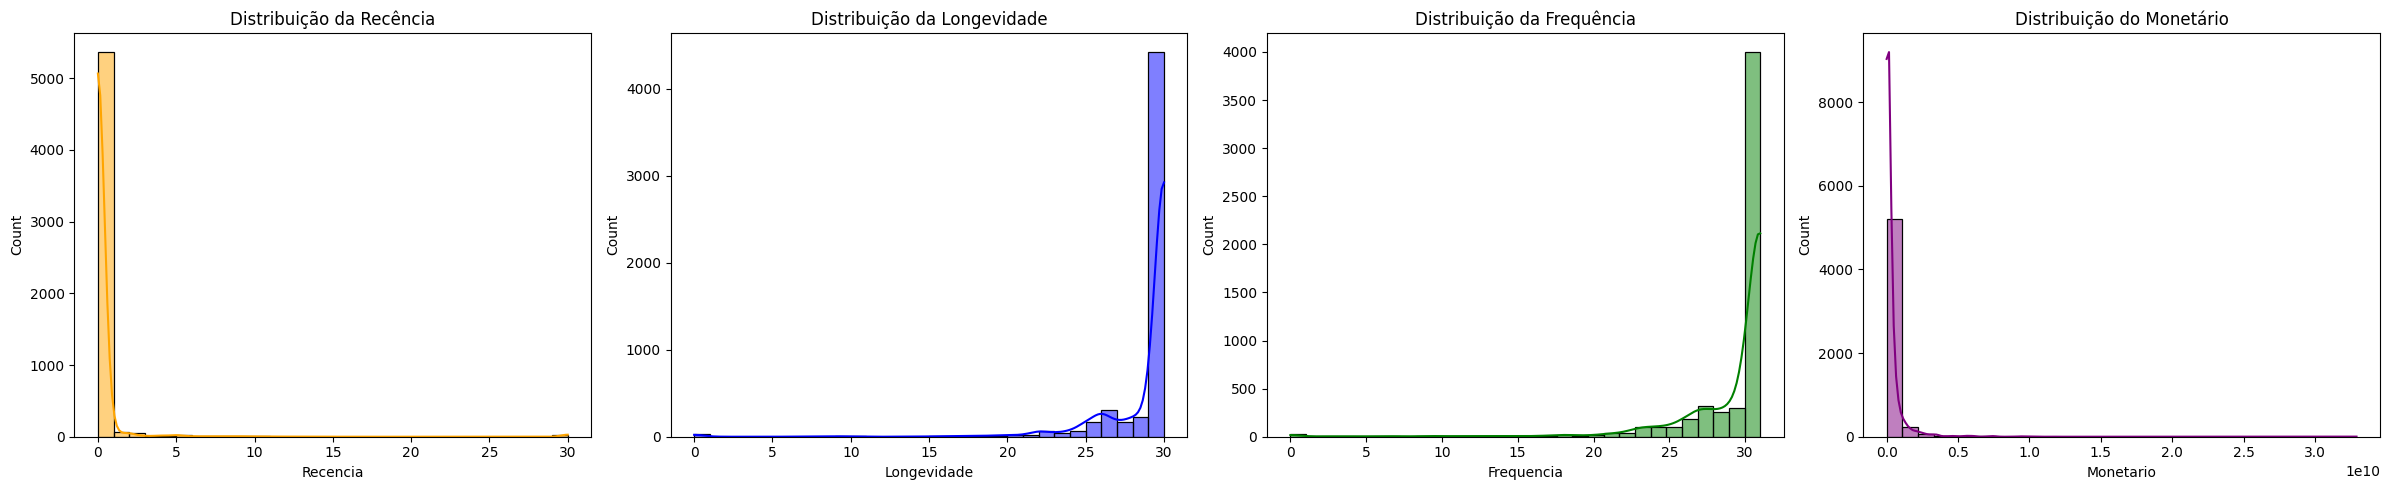

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando subplots para Recência, Longevidade, Frequência e Monetário no modelo LRFM
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

sns.histplot(rfm["Recencia"], bins=30, kde=True, ax=axes[0], color="orange")
axes[0].set_title("Distribuição da Recência")

sns.histplot(rfm["Longevidade"], bins=30, kde=True, ax=axes[1], color="blue")
axes[1].set_title("Distribuição da Longevidade")

sns.histplot(rfm["Frequencia"], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribuição da Frequência")

sns.histplot(rfm["Monetario"], bins=30, kde=True, ax=axes[3], color="purple")
axes[3].set_title("Distribuição do Monetário")

plt.tight_layout()
plt.show()


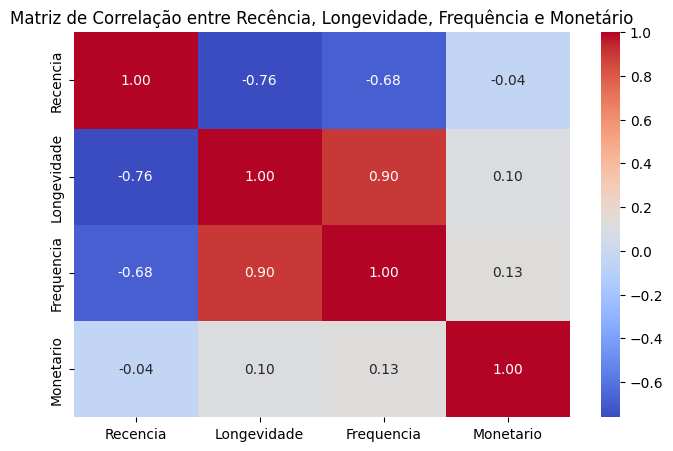

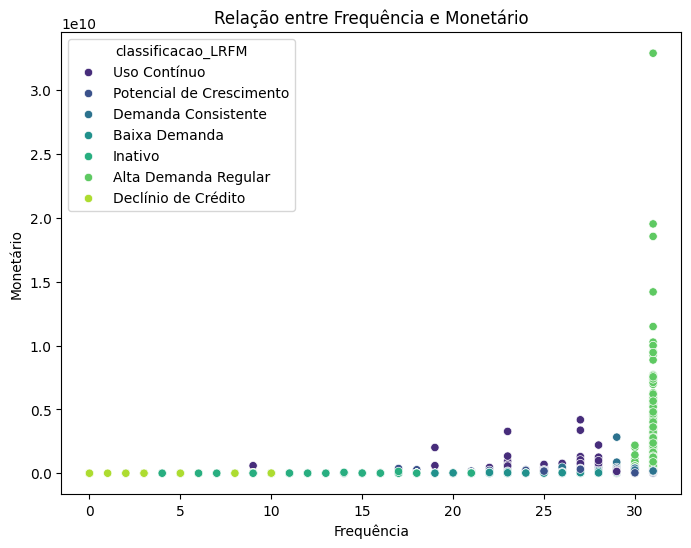

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔥 1️⃣ Matriz de Correlação com Recência, Longevidade, Frequência e Monetário
plt.figure(figsize=(8, 5))
sns.heatmap(
    rfm[["Recencia", "Longevidade", "Frequencia", "Monetario"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Matriz de Correlação entre Recência, Longevidade, Frequência e Monetário")
plt.show()

# 🔥 2️⃣ Scatterplot entre Frequência e Monetário, agora considerando LRFM
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm, x="Frequencia", y="Monetario", hue="classificacao_LRFM", palette="viridis"
)
plt.title("Relação entre Frequência e Monetário")
plt.xlabel("Frequência")
plt.ylabel("Monetário")
plt.show()


<ipython-input-77-22c630672832>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=rfm, x="classificacao_LRFM", y="Recencia", palette="viridis", ax=axes[0])
<ipython-input-77-22c630672832>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-77-22c630672832>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=rfm, x="classificacao_LRFM", y="Longevidade", palette="viridis", ax=axes[1])
<ipython-input-77-22c630672832>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() 

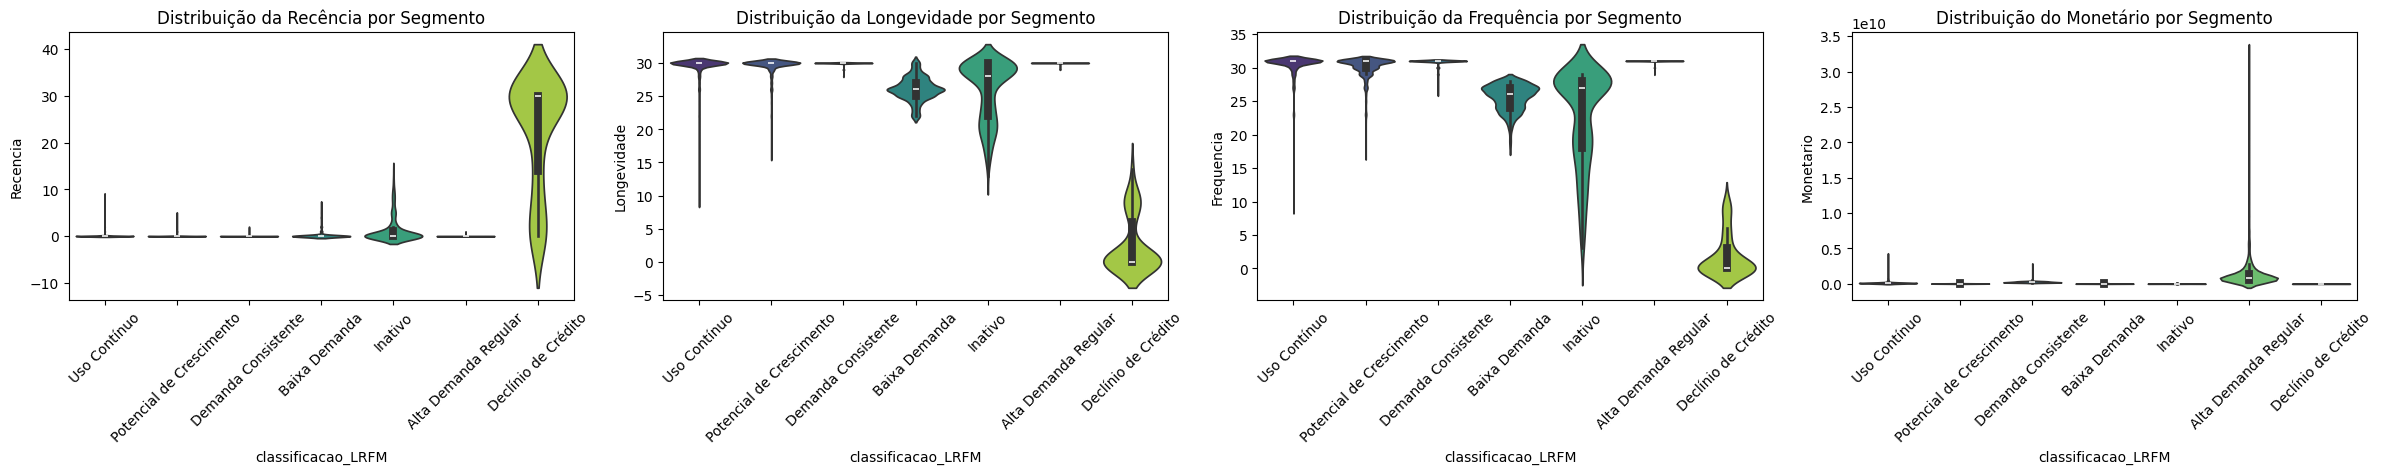

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando subplots para visualizar a distribuição das métricas por segmento LRFM
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

sns.violinplot(data=rfm, x="classificacao_LRFM", y="Recencia", palette="viridis", ax=axes[0])
axes[0].set_title("Distribuição da Recência por Segmento")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LRFM", y="Longevidade", palette="viridis", ax=axes[1])
axes[1].set_title("Distribuição da Longevidade por Segmento")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LRFM", y="Frequencia", palette="viridis", ax=axes[2])
axes[2].set_title("Distribuição da Frequência por Segmento")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LRFM", y="Monetario", palette="viridis", ax=axes[3])
axes[3].set_title("Distribuição do Monetário por Segmento")
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


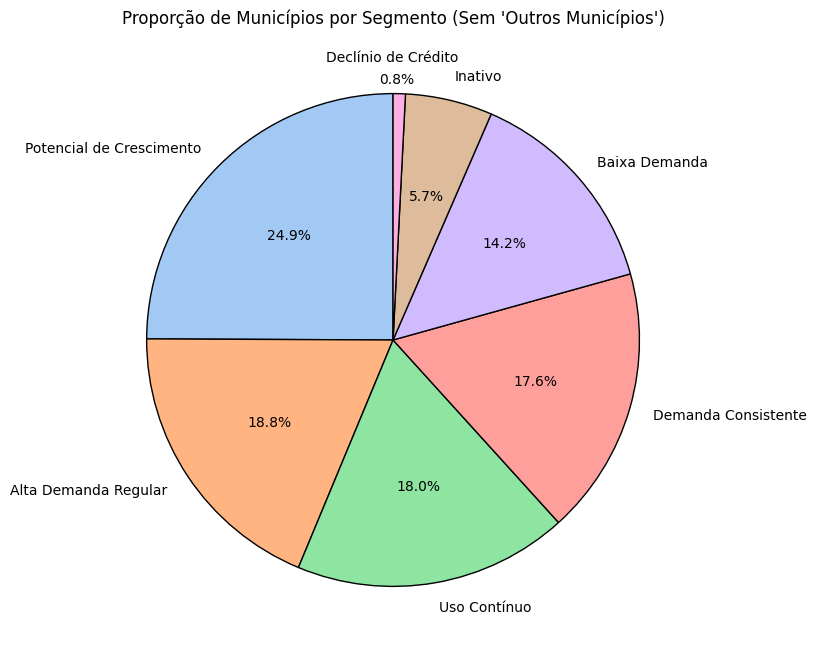

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar dados removendo "Outros Municípios" para uma análise mais relevante
rfm_filtrado = rfm[rfm["classificacao_LRFM"] != "Outros Municípios"]

# Contagem dos segmentos para plotagem
segment_counts = rfm_filtrado["classificacao_LRFM"].value_counts()

# Criar gráfico de pizza
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    segment_counts,
    labels=segment_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel"),
    startangle=90,
    wedgeprops={"edgecolor": "black"}
)

# Ajustar manualmente a posição do rótulo e porcentagem de "Declínio de Crédito"
for i, text in enumerate(texts):
    if text.get_text() == "Declínio de Crédito":
        text.set_y(text.get_position()[1] + 0.05)  # Mantém o rótulo um pouco acima
        text.set_x(text.get_position()[0] - 0.3)  # Move o rótulo um pouco para a esquerda
        percent_text = autotexts[i]

        # Move a porcentagem exatamente para cima da fatia rosa
        percent_text.set_y(text.get_position()[1] - 0.09)

# Título do gráfico
plt.title("Proporção de Municípios por Segmento (Sem 'Outros Municípios')")
plt.ylabel("")  # Remove o rótulo do eixo Y
plt.show()


In [121]:
from scipy.stats import f_oneway, levene
import pandas as pd

# Definir variáveis para análise estatística no modelo LRFM
variaveis = ["Recencia", "Longevidade", "Frequencia", "Monetario"]

# Criar dicionários para armazenar os resultados
resultados_anova = {}
resultados_levene = {}

# Calcular ANOVA e Teste de Levene para cada variável considerando os clusters
for var in variaveis:
    grupos = [rfm[var][rfm["cluster"] == i] for i in rfm["cluster"].unique()]
    resultados_anova[var] = f_oneway(*grupos)
    resultados_levene[var] = levene(*grupos)

# Criar DataFrame com os resultados
resultados_df = pd.DataFrame({
    "ANOVA_F": [resultados_anova[var].statistic for var in variaveis],
    "ANOVA_p": [resultados_anova[var].pvalue for var in variaveis],
    "Levene_F": [resultados_levene[var].statistic for var in variaveis],
    "Levene_p": [resultados_levene[var].pvalue for var in variaveis]
}, index=variaveis)

# Ajustar a exibição dos valores em notação científica forçada
pd.set_option("display.float_format", lambda x: f"{x:.5e}")  # Exibir 50 casas decimais em notação científica

# Exibir resultados
print("Resultados dos Testes ANOVA e Levene (Com Precisão Extrema para p-value):")
print(resultados_df)


Resultados dos Testes ANOVA e Levene (Com Precisão Extrema para p-value):
                ANOVA_F     ANOVA_p    Levene_F    Levene_p
Recencia    2.35024e+03 0.00000e+00 4.32768e+02 0.00000e+00
Longevidade 7.55681e+03 0.00000e+00 5.47090e+02 0.00000e+00
Frequencia  6.90491e+03 0.00000e+00 4.14010e+02 0.00000e+00
Monetario   5.66632e+03 0.00000e+00 4.35052e+02 0.00000e+00


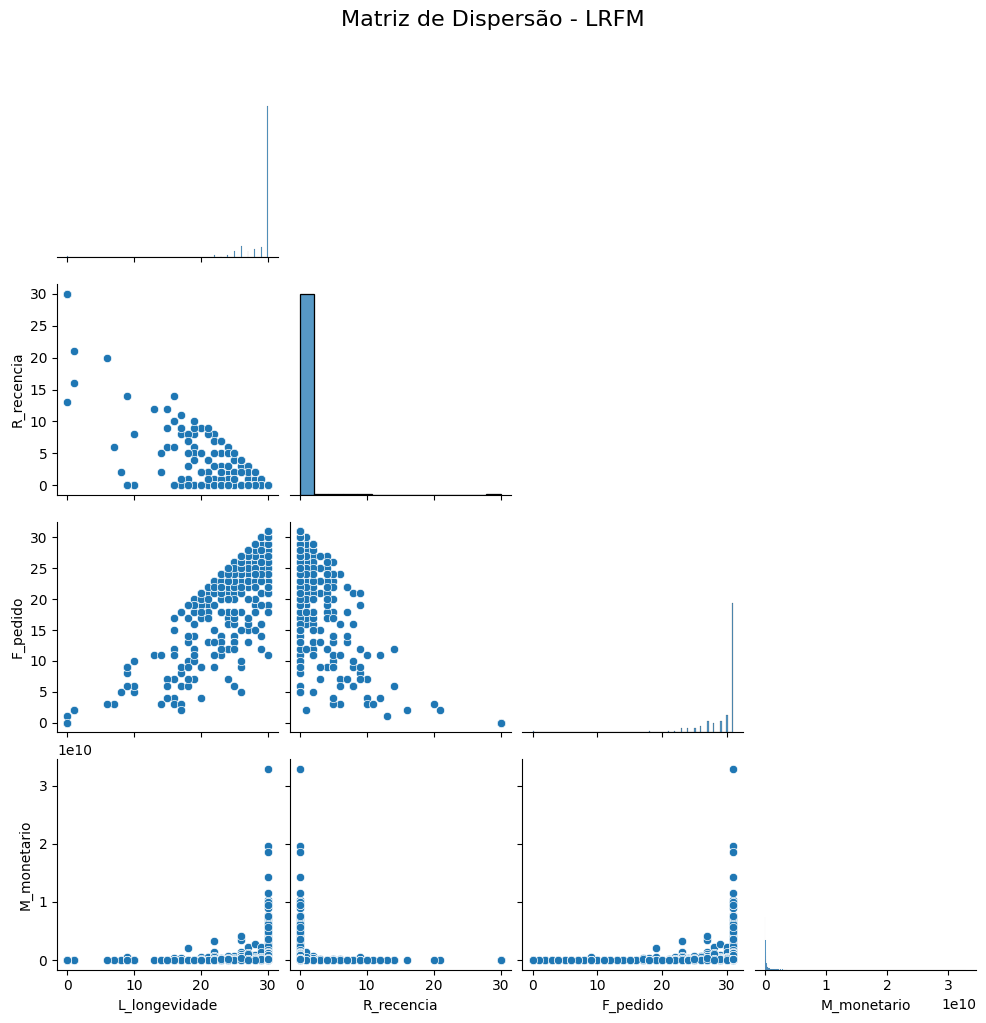

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar a Matriz de Dispersão no modelo LRFM
g = sns.pairplot(rfm_lr[["L_longevidade", "R_recencia", "F_pedido", "M_monetario"]], diag_kind='hist', corner=True)

# Ajustar título do gráfico
g.fig.suptitle("Matriz de Dispersão - LRFM", y=1.02, fontsize=16)
g.fig.set_size_inches(10, 10)  # Ajustar tamanho da figura

# Exibir gráfico
plt.show()
